### Imports

In [1]:
import numpy as np
import pickle
import cv2
import glob
import time
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import pandas as pd
from moviepy.editor import VideoFileClip
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label

In [2]:
import logging
logger = logging.getLogger('VEHICLE_DET')
hdlr = logging.FileHandler('./vehicle_det.log')
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr) 
logger.setLevel(logging.DEBUG)

### Data Exploration

In [3]:
car_images = glob.glob('./training_data/vehicles/*/*/*.png')
noncar_images = glob.glob('./training_data/non_vehicles/*/*/*.png')

In [4]:
from vehicle_detection import data_analysis

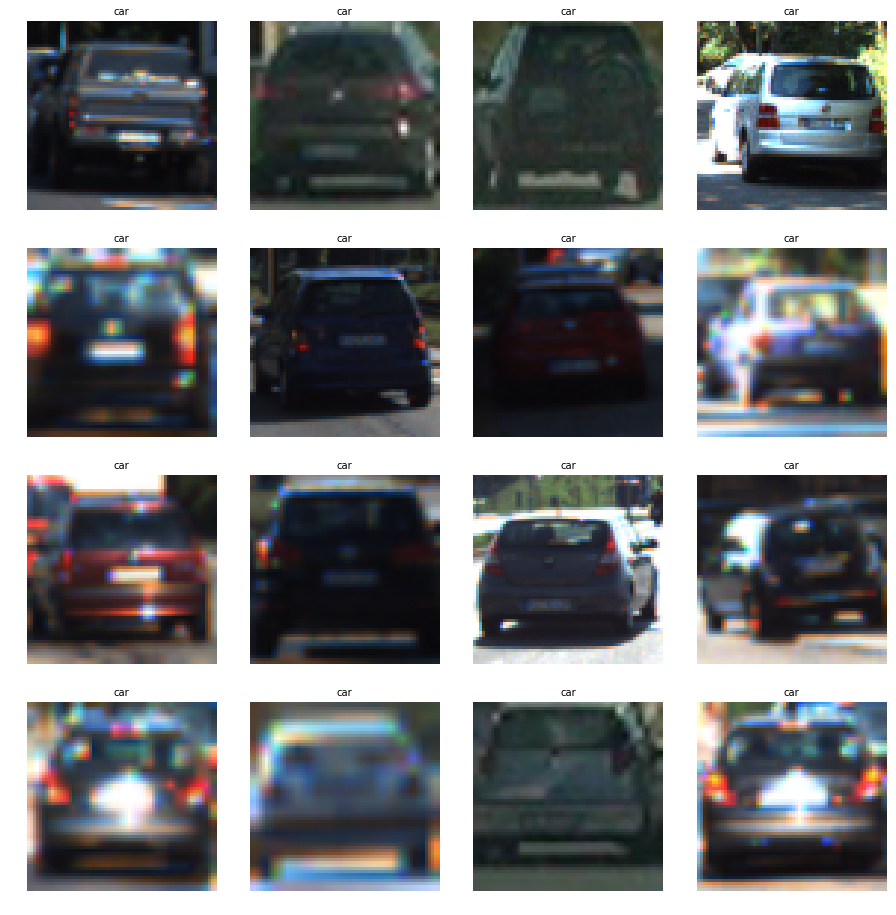

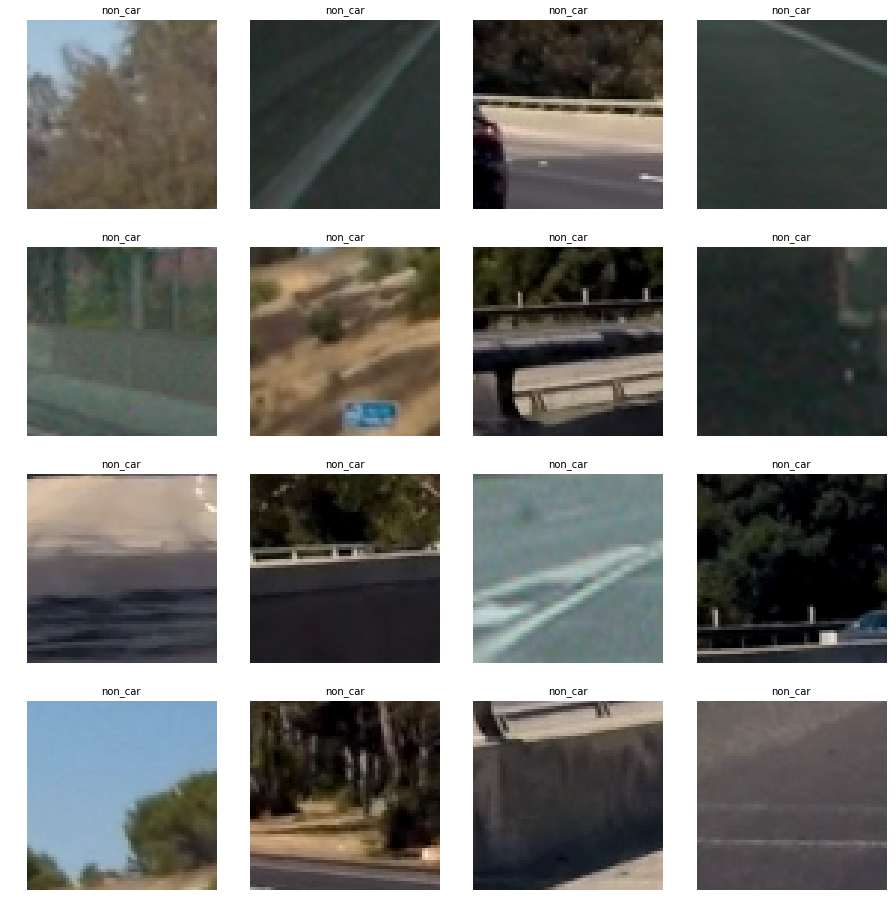

In [5]:
data_dict = data_analysis.explore_input_images(car_images, noncar_images, 16)

### Feature Extraction

In [6]:
from vehicle_detection import feature_extraction as feature

##### Hog Parameters

In [7]:
g_orient = 9
g_pix_per_cell = 8
g_cell_per_block = 2

##### Apply HOG on a random car and noncar image

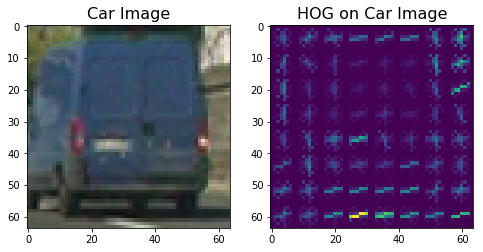

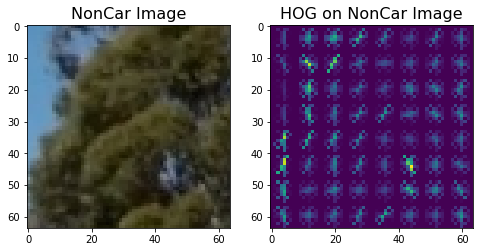

In [8]:
c_index = np.random.randint(0,len(car_images))
car_img = mpimg.imread(car_images[c_index])
car_features, car_hog = feature.get_hog_features(car_img[:,:,2], g_orient, g_pix_per_cell, g_cell_per_block, vis=True, feature_vec=True)
nonc_index = np.random.randint(0,len(noncar_images))
noncar_img = mpimg.imread(noncar_images[nonc_index])
noncar_features, noncar_hog = feature.get_hog_features(noncar_img[:,:,2], g_orient, g_pix_per_cell, g_cell_per_block, vis=True, feature_vec=True)
data_analysis.plot_as_subplots(car_img, car_hog, 'Car Image', 'HOG on Car Image')
data_analysis.plot_as_subplots(noncar_img, noncar_hog, 'NonCar Image', 'HOG on NonCar Image')

### Data Preparation for Classifier

In [9]:
from vehicle_detection import classifier

In [10]:
### TODO: Tweak these parameters and see how the results change.
g_colorspace = ['RGB', 'HSV', 'YUV']# Can be RGB, HSV, LUV, HLS, YUV, YCrCb
g_orient = [9, 10, 11, 12]
g_pix_per_cell = [8, 16]
g_cell_per_block = [1, 2, 4]
g_hog_channel = [0, 1, 2, "ALL"] # Can be 0, 1, 2, or "ALL"

In [ ]:
def hog_param_exploration(hog_param_df, colorspace, orient, pix_per_cell, cell_per_block, hog_channel):
    hog_params = {}
    count  = 0
    for color in g_colorspace:
        for orientation in orient:
            for pixel in pix_per_cell:
                for cell in cell_per_block:
                    for channel in hog_channel:
                        hog_params['cspace'] = color
                        hog_params['orient'] = orientation
                        hog_params['pix_per_cell'] = pixel
                        hog_params['cell_per_block'] = cell
                        hog_params['hog_channel'] =  channel
                        new_hog = pd.DataFrame(hog_params, index = [count])
                        logger.debug(new_hog)
                        hog_svc_data = classifier.train_hog_features(car_images, noncar_images, hog_params, logger)
                        new_svc = pd.DataFrame(hog_svc_data, index = [count])
                        logger.debug(new_svc)
                        hog_svc_df = pd.concat([new_hog, new_svc], axis=1)
                        logger.debug(hog_svc_df)
                        hog_param_df = hog_param_df.append(hog_svc_df)
                        count = count + 1
    display(hog_param_df)
    return hog_param_df

In [ ]:
hog_param_df = pd.DataFrame(columns=['cspace', 'orient', 'pix_per_cell', 'cell_per_block', 'hog_channel', 
                                     'feature_extraction_time', 'training_time', 'accuracy', 'prediction_time'])
hog_param_df = hog_param_exploration(hog_param_df, g_colorspace, g_orient, g_pix_per_cell, g_cell_per_block, g_hog_channel)

#### Sliding Window

In [ ]:
# windows = slide_window(image, x_start_stop=(None, None), y_start_stop=(None, None), 
#                     xy_window=(128, 128), xy_overlap=(0.5, 0.5))
                       
# window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
# plt.imshow(window_img)

In [ ]:
# # Reduce the sample size because
# # The quiz evaluator times out after 13s of CPU time
# sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

# ### TODO: Tweak these parameters and see how the results change.
# color_space = 'RGB' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
# orient = 9  # HOG orientations
# pix_per_cell = 8 # HOG pixels per cell
# cell_per_block = 2 # HOG cells per block
# hog_channel = 0 # Can be 0, 1, 2, or "ALL"
# spatial_size = (16, 16) # Spatial binning dimensions
# hist_bins = 16    # Number of histogram bins
# spatial_feat = True # Spatial features on or off
# hist_feat = True # Histogram features on or off
# hog_feat = True # HOG features on or off
# y_start_stop = [None, None] # Min and max in y to search in slide_window()

# car_features = extract_features(cars, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)
# notcar_features = extract_features(notcars, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)

# X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# # Fit a per-column scaler
# X_scaler = StandardScaler().fit(X)
# # Apply the scaler to X
# scaled_X = X_scaler.transform(X)

# # Define the labels vector
# y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# # Split up data into randomized training and test sets
# rand_state = np.random.randint(0, 100)
# X_train, X_test, y_train, y_test = train_test_split(
#     scaled_X, y, test_size=0.2, random_state=rand_state)

# print('Using:',orient,'orientations',pix_per_cell,
#     'pixels per cell and', cell_per_block,'cells per block')
# print('Feature vector length:', len(X_train[0]))
# # Use a linear SVC 
# svc = LinearSVC()
# # Check the training time for the SVC
# t=time.time()
# svc.fit(X_train, y_train)
# t2 = time.time()
# print(round(t2-t, 2), 'Seconds to train SVC...')
# # Check the score of the SVC
# print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# # Check the prediction time for a single sample
# t=time.time()

# image = mpimg.imread('bbox-example-image.jpg')
# draw_image = np.copy(image)

# # Uncomment the following line if you extracted training
# # data from .png images (scaled 0 to 1 by mpimg) and the
# # image you are searching is a .jpg (scaled 0 to 255)
# #image = image.astype(np.float32)/255

# windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, 
#                     xy_window=(96, 96), xy_overlap=(0.5, 0.5))

# hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
#                         spatial_size=spatial_size, hist_bins=hist_bins, 
#                         orient=orient, pix_per_cell=pix_per_cell, 
#                         cell_per_block=cell_per_block, 
#                         hog_channel=hog_channel, spatial_feat=spatial_feat, 
#                         hist_feat=hist_feat, hog_feat=hog_feat)                       

# window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

# plt.imshow(window_img)




#### duplicates and false positives